In [75]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timezone
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, MaxPooling1D, Conv1D, LSTM, SimpleRNN
from kerastuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import f1_score

In [76]:
# Create lagged DataFrame
def create_lagged_df(df, lags):
    df_lagged = pd.DataFrame()
    df_lagged['temp'] = df['Temp']
    df_lagged['Datetime'] = df['Datetime']
    for i in range(lags+1):
        if i == 0:
            df_lagged['t'] = df['Power']
        else:
            df_lagged['t-'+str(i)] = df['Power'].shift(i)
    return df_lagged.dropna()
dfs = []
for filename in os.listdir("Ruiqi Data"):
    df = pd.read_csv("Ruiqi Data/"+ filename)
    newDf = create_lagged_df(df, 3)
    if filename == 'MD.csv':
        newDf['Condition'] = 1
    elif filename == 'ND.csv':
        newDf['Condition'] = 0
    elif filename == 'SD.csv':
        newDf['Condition'] = 2
    dfs.append(newDf)
df = pd.concat(dfs, ignore_index=True)
df['t'] = (df['t'] - df['t'].mean()) / df['t'].std()
df['t-1'] = (df['t-1'] - df['t-1'].mean()) / df['t-1'].std()
df['t-2'] = (df['t-2'] - df['t-2'].mean()) / df['t-2'].std()
df['t-3'] = (df['t-3'] - df['t-3'].mean()) / df['t-3'].std()
df['temp'] = (df['temp'] - df['temp'].mean()) / df['temp'].std()
df['Year'] = 2021
df['Month'] = 1.0
df['Day'] = 1.0
df['Hour'] = 0.0
df['Minute'] = 0.0
df.reset_index(drop=True, inplace=True)
for i, row in df.iterrows():
    df.at[i, 'Year'] = int(str(df.at[i, 'Datetime']).split('-')[0])
    tempMonth = int(str(df.at[i, 'Datetime']).split('-')[1])
    if tempMonth in [1, 3, 5, 7, 8, 10, 12]:
        df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 31)
    elif tempMonth in [4, 6, 9, 11]:
        df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 30)
    elif (tempMonth in [2]) and df.at[i, 'Year'] % 4 == 0:
        df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 29)
    elif (tempMonth in [2]) and df.at[i, 'Year'] % 4 != 0:
        df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 28)
    else:
        print("error")
    df.at[i, 'Month'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[1])) / 12)
    df.at[i, 'Hour'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split(' ')[1].split(':')[0]) / 24))
    df.at[i, 'Minute'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split(' ')[1].split(':')[1]) / 60))

In [77]:
allData = df
train, test = train_test_split(df, test_size=0.2, random_state=42)
trainX = np.c_[train['temp'], train['t'], train['t-1'], train['t-2'], train['t-3'], train['Month'], train['Day'], train['Hour'], train['Minute']]
testX = np.c_[test['temp'], test['t'], test['t-1'], test['t-2'], test['t-3'], test['Month'], test['Day'], test['Hour'], test['Minute']]
trainY =  train['Condition'].to_numpy()
trainY = tf.keras.utils.to_categorical(trainY, 3)
testY = test['Condition'].to_numpy()
testY = tf.keras.utils.to_categorical(testY, 3)

def predict(model):
    for filename in os.listdir('Golf Club'):
        df = pd.read_excel('Golf Club/' + filename)
        df.rename(columns={'RealPower_avg':'Power', 'Temp_avg':'Temp'}, inplace=True)
        df['Datetime'] = df['Timecode'].apply(lambda x: datetime.fromtimestamp(x))
        df = create_lagged_df(df, 3)
        df = pd.concat(dfs, ignore_index=True)
        df['t'] = (df['t'] - df['t'].mean()) / df['t'].std()
        df['t-1'] = (df['t-1'] - df['t-1'].mean()) / df['t-1'].std()
        df['t-2'] = (df['t-2'] - df['t-2'].mean()) / df['t-2'].std()
        df['t-3'] = (df['t-3'] - df['t-3'].mean()) / df['t-3'].std()
        df['temp'] = (df['temp'] - df['temp'].mean()) / df['temp'].std()
        df['Year'] = 2021
        df['Month'] = 1.0
        df['Day'] = 1.0
        df['Hour'] = 0.0
        df['Minute'] = 0.0
        df.reset_index(drop=True, inplace=True)
        for i, row in df.iterrows():
            df.at[i, 'Year'] = int(str(df.at[i, 'Datetime']).split('-')[0])
            tempMonth = int(str(df.at[i, 'Datetime']).split('-')[1])
            if tempMonth in [1, 3, 5, 7, 8, 10, 12]:
                df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 31)
            elif tempMonth in [4, 6, 9, 11]:
                df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 30)
            elif (tempMonth in [2]) and df.at[i, 'Year'] % 4 == 0:
                df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 29)
            elif (tempMonth in [2]) and df.at[i, 'Year'] % 4 != 0:
                df.at[i, 'Day'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[2][:2])) / 28)
            else:
                print("error")
            df.at[i, 'Month'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split('-')[1])) / 12)
            df.at[i, 'Hour'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split(' ')[1].split(':')[0]) / 24))
            df.at[i, 'Minute'] = math.sin((2 * math.pi * float(str(df.at[i, 'Datetime']).split(' ')[1].split(':')[1]) / 60))
        predictionData = np.c_[df['temp'], df['t'], df['t-1'], df['t-2'], df['t-3'], df['Month'], df['Day'], df['Hour'], df['Minute']]
        predictions = model.predict(predictionData)
        predictions = [np.argmax(pred, axis=None, out=None) for pred in predictions]
        plt.plot(predictions[:10000])
        plt.xlabel('Time')
        plt.ylabel('Degradation Score')
        plt.show()
        print(sum(predictions) / len(predictions))
        break

In [78]:
# IF ERROR ARISES REMOVE THIS CELL
from sklearn.decomposition import PCA

pcaData = df[['temp', 't', 't-1', 't-2', 't-3', 'Condition', 'Month', 'Day', 'Hour', 'Minute']]

pcaFit = pd.DataFrame(pcaData)
matrix = pcaFit.corr()
print(matrix)
target_correlations = matrix["t"].sort_values(ascending=False)
print(target_correlations)

                   temp         t       t-1       t-2       t-3     Condition  \
temp       1.000000e+00  0.662469  0.663409  0.663581  0.663036 -2.344637e-15   
t          6.624695e-01  1.000000  0.985073  0.968488  0.950371  1.142742e-01   
t-1        6.634091e-01  0.985073  1.000000  0.985073  0.968488  1.142742e-01   
t-2        6.635808e-01  0.968488  0.985073  1.000000  0.985073  1.142742e-01   
t-3        6.630364e-01  0.950371  0.968488  0.985073  1.000000  1.142742e-01   
Condition -2.344637e-15  0.114274  0.114274  0.114274  0.114274  1.000000e+00   
Month     -5.305271e-01 -0.302639 -0.302716 -0.302796 -0.302879 -1.846885e-15   
Day        3.165890e-02 -0.030957 -0.030948 -0.030936 -0.030918 -1.164843e-16   
Hour      -1.163287e-01 -0.271008 -0.297670 -0.323664 -0.348942 -4.911887e-18   
Minute     9.944159e-06 -0.002839 -0.002747  0.002881  0.002788 -3.530806e-19   

                  Month           Day          Hour        Minute  
temp      -5.305271e-01  3.165890e-02 -1

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input((9,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'f1_score'])
    return model
seeds = [42, 84, 126]
f1Errors = []
for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    early_stopping_callback = EarlyStopping(monitor='loss', patience=3)
    tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10)
    tuner.search(trainX, trainY, epochs=300, verbose=0, callbacks=[early_stopping_callback])
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.fit(trainX, trainY, epochs=300, verbose=0, batch_size=32, callbacks=[early_stopping_callback])
    testresults = best_model.evaluate(testX, testY)
    trainresults = best_model.evaluate(trainX, trainY)
    predicted = best_model.predict(testX)
    f1 = f1_score([np.argmax(test, axis=None, out=None) for test in testY], [np.argmax(pred, axis=None, out=None) for pred in predicted], average='macro')
    f1Errors.append(f1)
    #print(best_model.metrics_names)
    #print(testresults['f1_score'])
    #predict(best_model)
print("Average testing F1 score: ", sum(f1Errors)/len(f1Errors))

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

def build_model(hp):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(9, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])
    return model
seeds = [42, 84, 126]
f1Errors = []
for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    early_stopping_callback = EarlyStopping(monitor='loss', patience=3)
    tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10)
    tuner.search(trainX, trainY, epochs=300, verbose=0, callbacks=[early_stopping_callback])
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.fit(trainX, trainY, epochs=300, verbose=0, batch_size=32, callbacks=[early_stopping_callback])
    testresults = best_model.evaluate(testX, testY)
    trainresults = best_model.evaluate(trainX, trainY)
    predicted = best_model.predict(testX)
    f1 = f1_score([np.argmax(test, axis=None, out=None) for test in testY], [np.argmax(pred, axis=None, out=None) for pred in predicted], average='macro')
    f1Errors.append(f1)
    #print(best_model.metrics_names)
    #print(testresults['f1_score'])
    #predict(best_model)
print("Average testing F1 score: ", sum(f1Errors)/len(f1Errors))

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

def build_model(hp):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(9, 1)))
    model.add(Dropout(0.02))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.02))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])
    return model

seeds = [42, 84, 126]
f1Errors = []
for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    early_stopping_callback = EarlyStopping(monitor='loss', patience=3)
    tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10)
    tuner.search(trainX, trainY, epochs=300, verbose=0, callbacks=[early_stopping_callback])
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.fit(trainX, trainY, epochs=300, verbose=0, batch_size=32, callbacks=[early_stopping_callback])
    testresults = best_model.evaluate(testX, testY)
    trainresults = best_model.evaluate(trainX, trainY)
    predicted = best_model.predict(testX)
    f1 = f1_score([np.argmax(test, axis=None, out=None) for test in testY], [np.argmax(pred, axis=None, out=None) for pred in predicted], average='macro')
    f1Errors.append(f1)
    #print(best_model.metrics_names)
    #print(testresults['f1_score'])
    #predict(best_model)
print("Average testing F1 score: ", sum(f1Errors)/len(f1Errors))

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(64, return_sequences=True, input_shape=(9,1), activation='relu'))
    model.add(SimpleRNN(32, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(16, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])
    return model

seeds = [42, 84, 126]
f1Errors = []
for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    early_stopping_callback = EarlyStopping(monitor='loss', patience=3)
    tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10)
    tuner.search(trainX, trainY, epochs=300, verbose=0, callbacks=[early_stopping_callback])
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.fit(trainX, trainY, epochs=300, verbose=0, batch_size=32, callbacks=[early_stopping_callback])
    testresults = best_model.evaluate(testX, testY)
    trainresults = best_model.evaluate(trainX, trainY)
    predicted = best_model.predict(testX)
    f1 = f1_score([np.argmax(test, axis=None, out=None) for test in testY], [np.argmax(pred, axis=None, out=None) for pred in predicted], average='macro')
    f1Errors.append(f1)
    #print(best_model.metrics_names)
    #print(testresults['f1_score'])
    #predict(best_model)
print("Average testing F1 score: ", sum(f1Errors)/len(f1Errors))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

seeds = [42, 84, 126]
f1Errors = []
for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    rf_model = RandomForestClassifier(random_state=seed)
    random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_grid,
        scoring='f1_macro'
    )
    random_search.fit(trainX, trainY)
    y_pred = random_search.predict(testX)
    accuracy = accuracy_score(testY, y_pred)
    f1 = f1_score(testY, y_pred, average='macro')
    f1Errors.append(f1)
    best_params = random_search.best_params_
    print("Best hyperparameters:", best_params)
    #confusion = confusion_matrix([np.argmax(test, axis=None, out=None) for test in testY], [np.argmax(pred, axis=None, out=None) for pred in y_pred])
    print("Accuracy: ", accuracy)
    print("F1 Score: ", f1)
print("Average F1 Score: ", sum(f1Errors)/len(f1Errors))

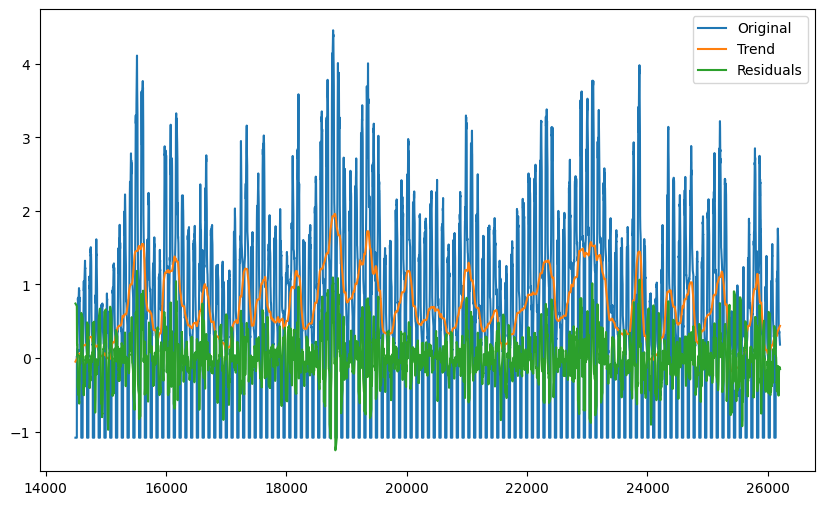

Moderate Degradation
Degradation rate: -1.4639996314503007e-08


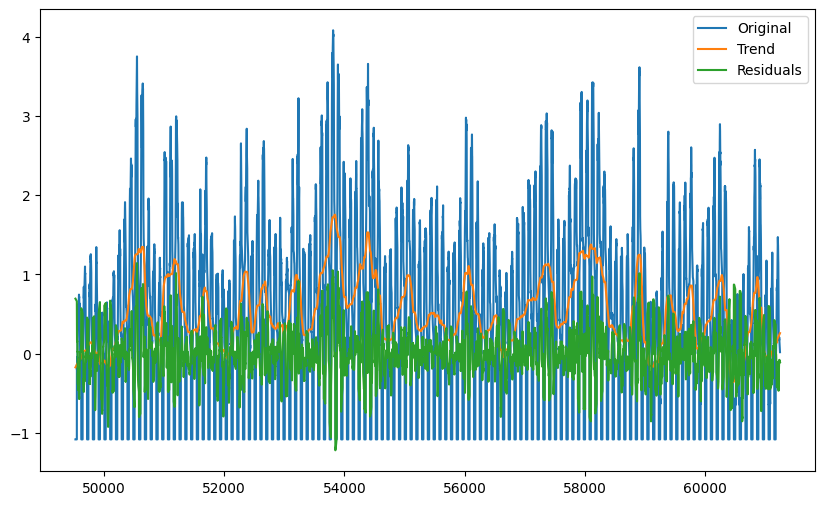

No Degradation
Degradation rate: -5.65713529348612e-06


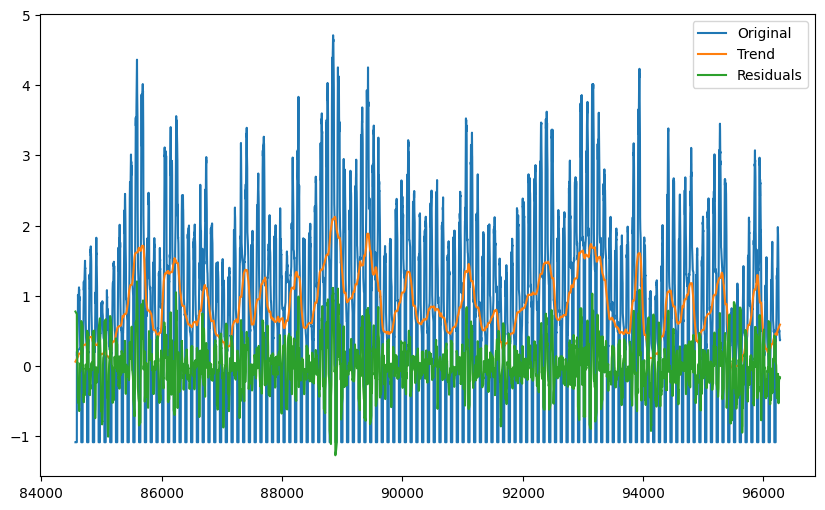

Severe Degradation
Degradation rate: -5.4069050023503125e-06


In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

# only include summer
dfs = []
for filename in os.listdir("Ruiqi Data"):
    df = pd.read_csv("Ruiqi Data/"+ filename)
    newDf = create_lagged_df(df, 3)
    if filename == 'MD.csv':
        newDf['Condition'] = 1
    elif filename == 'ND.csv':
        newDf['Condition'] = 0
    elif filename == 'SD.csv':
        newDf['Condition'] = 2
    dfs.append(newDf)
df = pd.concat(dfs, ignore_index=True)
df['t'] = (df['t'] - df['t'].mean()) / df['t'].std()
df['t-1'] = (df['t-1'] - df['t-1'].mean()) / df['t-1'].std()
df['t-2'] = (df['t-2'] - df['t-2'].mean()) / df['t-2'].std()
df['t-3'] = (df['t-3'] - df['t-3'].mean()) / df['t-3'].std()
df['Datetime'] = pd.to_datetime(df['Datetime'])
allData = df[(df['Datetime'].dt.month > 5) & (df['Datetime'].dt.month < 10)]
# period is set up for 96 15 minute cycles (1 day)
result = seasonal_decompose(allData['t'][:int(len(allData['t'])/3)], model='additive', period=96, extrapolate_trend='freq')
trend_slope = np.polyfit(np.arange(len(allData['t'][:int(len(allData['t'])/3)])), result.trend, deg=2)[0]
degradation_rate = trend_slope / len(allData['t'][:int(len(allData['t'])/3)]) 
plt.figure(figsize=(10, 6))
plt.plot(allData.index[:int(len(allData['t'])/3)], allData['t'][:int(len(allData['t'])/3)], label='Original')
plt.legend()
plt.plot(allData.index[:int(len(allData['t'])/3)], result.trend, label='Trend')
plt.legend()
plt.plot(allData.index[:int(len(allData['t'])/3)], result.resid, label='Residuals')
plt.legend()
plt.show()
print("Moderate Degradation")
print(f"Degradation rate: {trend_slope}")

result = seasonal_decompose(allData['t'][int(len(allData['t'])/3):int(2*len(allData['t'])/3)], model='additive', period=96, extrapolate_trend='freq')
trend_slope = np.polyfit(np.arange(len(allData['t'][int(len(allData['t'])/3):int(2*len(allData['t'])/3)])), result.trend, deg=1)[0]
degradation_rate = trend_slope / len(allData['t'][int(len(allData['t'])/3):int(2*len(allData['t'])/3)]) 
plt.figure(figsize=(10, 6))
plt.plot(allData.index[int(len(allData['t'])/3):int(2*len(allData['t'])/3)], allData['t'][int(len(allData['t'])/3):int(2*len(allData['t'])/3)], label='Original')
plt.legend()
plt.plot(allData.index[int(len(allData['t'])/3):int(2*len(allData['t'])/3)], result.trend, label='Trend')
plt.legend()
plt.plot(allData.index[int(len(allData['t'])/3):int(2*len(allData['t'])/3)], result.resid, label='Residuals')
plt.legend()
plt.show()
print("No Degradation")
print(f"Degradation rate: {trend_slope}")

result = seasonal_decompose(allData['t'][int(2*len(allData['t'])/3):], model='additive', period=96, extrapolate_trend='freq')
trend_slope = np.polyfit(np.arange(len(allData['t'][int(2*len(allData['t'])/3):])), result.trend, deg=1)[0]
degradation_rate = trend_slope / len(allData['t'][int(2*len(allData['t'])/3):]) 
plt.figure(figsize=(10, 6))
plt.plot(allData.index[int(2*len(allData['t'])/3):], allData['t'][int(2*len(allData['t'])/3):], label='Original')
plt.legend()
plt.plot(allData.index[int(2*len(allData['t'])/3):], result.trend, label='Trend')
plt.legend()
plt.plot(allData.index[int(2*len(allData['t'])/3):], result.resid, label='Residuals')
plt.legend()
plt.show()
print("Severe Degradation")
print(f"Degradation rate: {trend_slope}")

In [80]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# fit vector autoregression model
model = sm.tsa.VAR(np.asarray(allData[['t', 'temp']][:int(len(allData)/3)]))
results = model.fit(maxlags=4)
dw_statistic = sm.stats.stattools.durbin_watson(results.resid)
print(dw_statistic)

model = sm.tsa.VAR(np.asarray(allData[['t', 'temp']][int(len(allData)/3):int(2*len(allData)/3)]))
results = model.fit(maxlags=4)
# Check for serial correlation of residuals (Durbin Watson Statistic)
dw_statistic = sm.stats.stattools.durbin_watson(results.resid)
print(dw_statistic)

model = sm.tsa.VAR(np.asarray(allData[['t', 'temp']][int(2*len(allData)/3):]))
results = model.fit(maxlags=4)
dw_statistic = sm.stats.stattools.durbin_watson(results.resid)
print(dw_statistic)

print(adfuller(np.asarray(allData[['t']][:int(len(allData)/3)])))
print(adfuller(np.asarray(allData[['t']][int(len(allData)/3):int(2*len(allData)/3)])))
print(adfuller(np.asarray(allData[['t']][int(2*len(allData)/3):])))

[2.0058388 2.0154903]
[2.00589525 2.01527194]
[2.00555349 2.01527409]
(-20.980629197812842, 0.0, 40, 11671, {'1%': -3.430910426600029, '5%': -2.8617876791254813, '10%': -2.566901834519924}, -929.7961345094118)
(-20.158013532621148, 0.0, 40, 11671, {'1%': -3.430910426600029, '5%': -2.8617876791254813, '10%': -2.566901834519924}, -3710.537903799177)
(-21.86140223663127, 0.0, 40, 11671, {'1%': -3.430910426600029, '5%': -2.8617876791254813, '10%': -2.566901834519924}, 1333.9359001587836)
